In [ ]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats

In [19]:
import os
os.chdir('/content/drive/MyDrive/Tensorflow Advance/Practice/CatDog')

import tensorflow as tf
from shutil import move
import zipfile
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image
import imageio
import random

In [ ]:
f = zipfile.ZipFile('./train.zip','r')
f.extractall()

In [ ]:
os.mkdir("data")
os.mkdir("./data/train")
os.mkdir("./data/train/dog")
os.mkdir("./data/train/cat")

In [ ]:
os.mkdir("./data/test")
os.mkdir("./data/test/dog")
os.mkdir("./data/test/cat")

In [6]:
data_dir = "./train/"

train_des_dir_dog = "./data/train/dog/"
train_des_dir_cat = "./data/train/cat/"

test_des_dir_dog = "./data/test/dog/"
test_des_dir_cat = "./data/test/cat/"

In [ ]:
len(os.listdir(data_dir))

25000

In [ ]:
for fl in os.listdir(data_dir):
    if 'cat' in fl:
        a = move(data_dir+fl , train_des_dir_dog)
    elif 'dog' in fl:
        a = move(data_dir+fl , train_des_dir_cat)

In [ ]:
print("Tota no of cat images : ",len(os.listdir(train_des_dir_dog)))
print("Tota no of dog images : ",len(os.listdir(train_des_dir_cat)))

Tota no of cat images :  12500
Tota no of dog images :  12500


In [ ]:
for fl in os.listdir(train_des_dir_dog)[-2500:]:
    a = move(train_des_dir_dog+fl , test_des_dir_dog)

In [ ]:
for fl in os.listdir(train_des_dir_cat)[-2500:]:
    a = move(train_des_dir_cat+fl , test_des_dir_cat)

In [7]:
train_dir = "./data/train/"
test_dir  = "./data/test/"

In [8]:
def print_dir_details(d):
    for dir in os.listdir(d): 
        print("No of %s is : %d"%(dir , len(os.listdir(d+dir))))

In [ ]:
print("TRAIN DATA DETAILS :\n====================================")
print_dir_details(train_dir)

print("TEST  DATA DETAILS :\n====================================")
print_dir_details(test_dir)

In [ ]:
shutil.rmtree(data_dir)

In [10]:
train_data_gen  =  tf.keras.preprocessing.image.ImageDataGenerator(rescale=(1.0 / 255.0))
test_data_gen   =  tf.keras.preprocessing.image.ImageDataGenerator(rescale=(1.0 / 255.0))

In [11]:
train_data = train_data_gen.flow_from_directory(train_dir ,
                                                target_size=(150,150),
                                                class_mode='binary' ,
                                                batch_size=64)

test_data = test_data_gen.flow_from_directory(test_dir ,
                                              target_size=(150,150),
                                              class_mode='binary' ,
                                              batch_size=64)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [12]:
print("Image shape : ",train_data[0][0][0].shape)
print("label shape : ",train_data[0][1][0].shape)

Image shape :  (150, 150, 3)
label shape :  ()


In [13]:
def get_basic_toy_cnn_model():
    #toy modle
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128,(3,3),activation=tf.nn.relu , input_shape=(150,150,3)),
        tf.keras.layers.MaxPool2D((2,2)),

        tf.keras.layers.Conv2D(64,(3,3),activation=tf.nn.relu ),
        tf.keras.layers.MaxPool2D((2,2)),

        tf.keras.layers.Conv2D(32,(3,3),activation=tf.nn.relu ),
        tf.keras.layers.MaxPool2D((2,2)),
        
        tf.keras.layers.Conv2D(32,(3,3),activation=tf.nn.relu ),
        tf.keras.layers.MaxPool2D((2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128,activation=tf.nn.relu , kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128,activation=tf.nn.relu , kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1 , activation=tf.nn.sigmoid)
    ])
    model.compile(optimizer=tf.keras.optimizers.RMSprop() ,
                loss = tf.keras.losses.binary_crossentropy ,
                metrics = ['acc'])
    return model

In [24]:
def display_image(image , output , y_true):
    plt.clf()
    plt.figure(figsize=(18,4))
    mod_output = []
    plt.xticks([])
    plt.yticks([])
    plt.grid(None)
    for i in output:
        if i==1:
            mod_output.append('CAT')
        else:
            mod_output.append('DOG')
    a = np.swapaxes(image, 0 , 1).reshape((150,900,3))
    plt.imshow(a)
    plt.xticks([150 * x + 75 for x in range(6)] , mod_output)

    for i in range(len(plt.gca().xaxis.get_ticklabels())):
        if y_true[i] == output[i]:
            plt.gca().xaxis.get_ticklabels()[i].set_color('green')
            plt.gca().xaxis.get_ticklabels()[i].set_fontsize(20)
        else:
            plt.gca().xaxis.get_ticklabels()[i].set_color('red')
            plt.gca().xaxis.get_ticklabels()[i].set_fontsize(20)

    plt.grid(None)

In [39]:
class MyOwnCallBacks(tf.keras.callbacks.Callback):
    def __init__(self , data , label):
        self.data = data
        self.label = label
        self.images = []
        self.loss   = []
        self.val_loss = []
        self.acc = []
        self.val_acc = []
        self.images_loss = []

    def on_epoch_end(self,epoch,logs={}):
        rand_6_num = np.random.choice(np.arange(64) , size=6)
        display_image(self.data[rand_6_num] , self.model.predict_classes(self.data[rand_6_num]).reshape((6,)) ,
                      self.label[rand_6_num])
        name = "img.png"
        plt.savefig(name)
        image = Image.open(name)
        self.images.append(np.array(image))

        if epoch % 4 == 0:
            plt.show()
        self.loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        ##################
        self.acc.append(logs['acc'])
        self.val_acc.append(logs['val_acc'])


        plt.clf()
        _ , ax = plt.subplots(1,2,figsize=(14 , 5))
        ax[0].plot(self.loss , label="Training loss")
        ax[0].plot(self.val_loss , label="Testing  loss")
        ax[0].legend()
        ax[1].plot(self.acc , label="Training acc")
        ax[1].plot(self.val_acc , label="Testing  acc")
        ax[1].legend()
        ax[0].set_title("CEOSSENTROPY")
        ax[1].set_title("ACCURECY!")
        name = "img_loss.png"
        plt.savefig(name)
        image = Image.open(name)
        self.images_loss.append(np.array(image))
        if epoch % 4 == 0:
            plt.show()
        if logs['val_loss'] / logs['loss'] > 1.5:
            print("OVERFITTING START !!!")
            self.model.stop_training = True
    def on_train_end(self , logs = {}):
        imageio.mimsave('./animation_mod.gif' , self.images , fps = 1)
        imageio.mimsave('./animation_loss_mod.gif' , self.images_loss , fps = 1)

Epoch 1/20
312/312 [==============================] - ETA: 0s - loss: 0.6689 - acc: 0.5938

<Figure size 432x288 with 0 Axes>

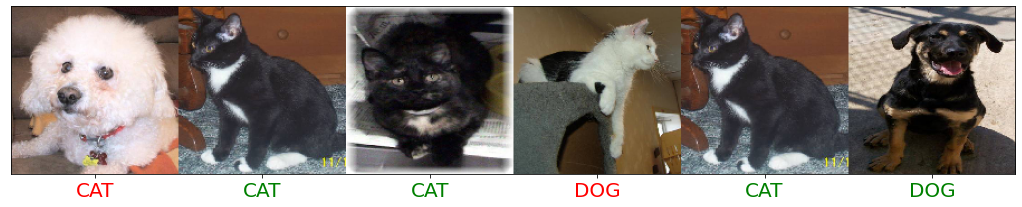

<Figure size 432x288 with 0 Axes>

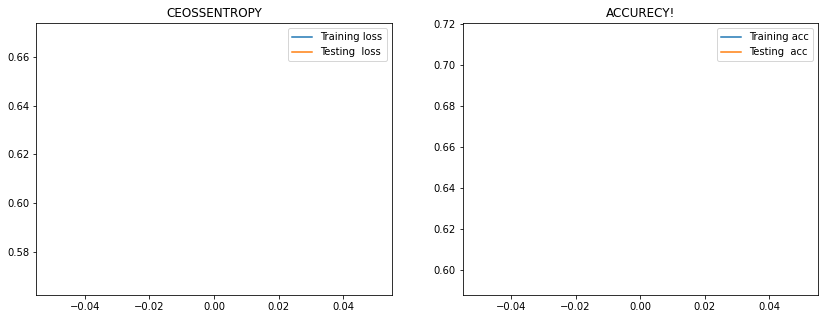

312/312 [==============================] - 94s 303ms/step - loss: 0.6689 - acc: 0.5938 - val_loss: 0.5673 - val_acc: 0.7143
Epoch 2/20
312/312 [==============================] - 91s 291ms/step - loss: 0.5468 - acc: 0.7289 - val_loss: 0.4829 - val_acc: 0.7794
Epoch 3/20
312/312 [==============================] - 90s 289ms/step - loss: 0.4652 - acc: 0.7892 - val_loss: 0.4914 - val_acc: 0.7875
Epoch 4/20
312/312 [==============================] - 91s 291ms/step - loss: 0.4120 - acc: 0.8201 - val_loss: 0.4178 - val_acc: 0.8157
Epoch 5/20
312/312 [==============================] - ETA: 0s - loss: 0.3756 - acc: 0.8411

<Figure size 432x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

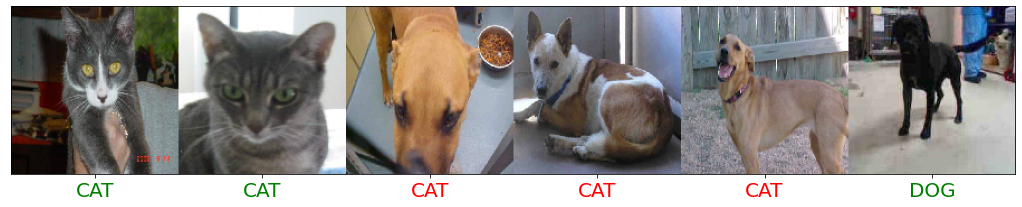

<Figure size 432x288 with 0 Axes>

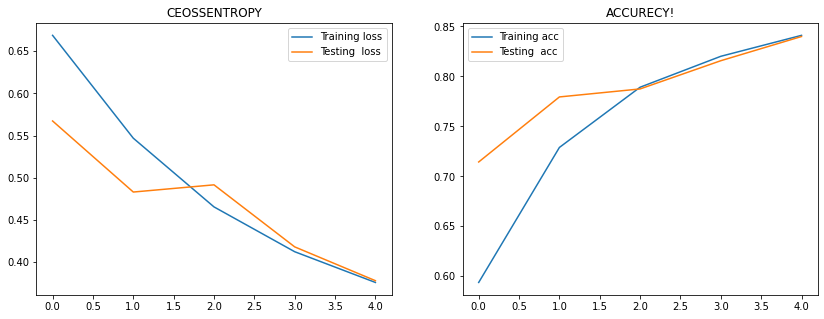

312/312 [==============================] - 91s 292ms/step - loss: 0.3756 - acc: 0.8411 - val_loss: 0.3777 - val_acc: 0.8399
Epoch 6/20
312/312 [==============================] - 91s 291ms/step - loss: 0.3395 - acc: 0.8595 - val_loss: 0.3460 - val_acc: 0.8540
Epoch 7/20
312/312 [==============================] - 92s 294ms/step - loss: 0.3040 - acc: 0.8761 - val_loss: 0.3225 - val_acc: 0.8650
Epoch 8/20
312/312 [==============================] - 91s 290ms/step - loss: 0.2791 - acc: 0.8907 - val_loss: 0.3504 - val_acc: 0.8584
Epoch 9/20
312/312 [==============================] - ETA: 0s - loss: 0.2531 - acc: 0.9022

<Figure size 432x288 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

<Figure size 1296x288 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

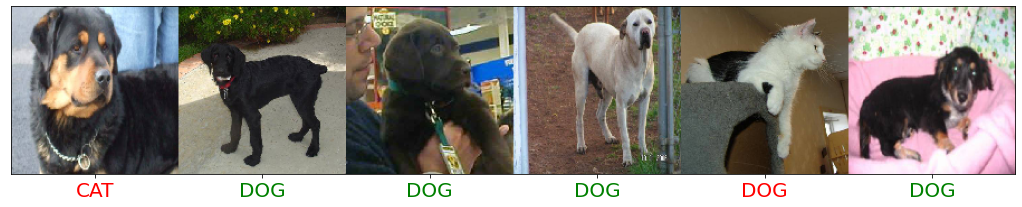

<Figure size 432x288 with 0 Axes>

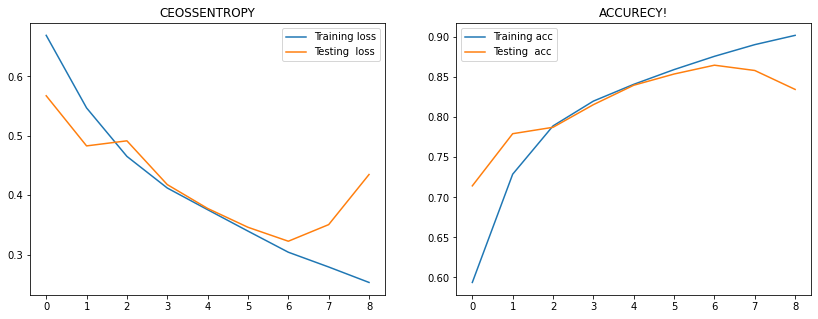

OVERFITTING START !!!
312/312 [==============================] - 91s 292ms/step - loss: 0.2531 - acc: 0.9022 - val_loss: 0.4348 - val_acc: 0.8347


In [40]:
model = get_basic_toy_cnn_model()
rand_ind = random.randint(0 , test_data.n // test_data.batch_size)
cb = MyOwnCallBacks(test_data[0][0] , test_data[0][1])
history = model.fit(train_data ,
          steps_per_epoch=train_data.n // train_data.batch_size ,
          epochs=20 ,
          validation_data=test_data ,
          validation_steps=test_data.n // test_data.batch_size,
          callbacks = [cb]
)